In [60]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab Notebooks/
%pwd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks


'/content/drive/MyDrive/Colab Notebooks'

In [61]:
!pip install colab-env -qU #To get utils.py working, might be unneccesary
import numpy as np
import pandas as pd
from scipy import stats
import keras
from keras.layers import Activation, Dense, Conv1D, Conv2D, MaxPooling1D, Flatten, Reshape
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import librosa
import utils
import seaborn as sn
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping

In [62]:
tracks = utils.load('Data/fma_metadata/tracks.csv')
genres = utils.load('Data/fma_metadata/genres.csv')
features = utils.load('Data/fma_metadata/features.csv')
subset = tracks.index[tracks['set', 'subset'] <= 'small']
tracks = tracks.loc[subset]
train = tracks.index[tracks['set', 'split'] == 'training']
val = tracks.index[tracks['set', 'split'] == 'validation']
test = tracks.index[tracks['set', 'split'] == 'test']

print('{} training examples, {} validation examples, {} testing examples'.format(*map(len, [train, val, test])))

6400 training examples, 800 validation examples, 800 testing examples


In [63]:
enc = LabelEncoder()
labels = tracks['track', 'genre_top']
# Split in training, validation and testing sets.
y_train = enc.fit_transform(labels[train])
y_val = enc.transform(labels[val])
y_test = enc.transform(labels[test])
X_train = features.loc[train, 'mfcc'].to_numpy()
X_val = features.loc[val, 'mfcc'].to_numpy()
X_test = features.loc[test, 'mfcc'].to_numpy()
# Standardize features by removing the mean and scaling to unit variance.
scaler = StandardScaler(copy=False)
scaler.fit_transform(X_train)
scaler.transform(X_val)
scaler.transform(X_test)
X_train_not_shuffled = X_train
X_train, y_train = shuffle(X_train, y_train, random_state=42)

In [64]:
X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape #sanity check

((6400, 140), (800, 140), (800, 140), (6400,), (800,), (800,))

Feed forward network trained on Mfcc features from fma\_metadata.

In [68]:
import tensorflow.keras as keras
model = keras.Sequential([
    # 1st dense layer
    keras.layers.Dense(128, input_dim=X_train.shape[1],activation='relu', kernel_regularizer = keras.regularizers.l2(0.002)),
    keras.layers.Dropout(0.3),
    # 2nd dense layer
    keras.layers.Dense(64, activation='relu', kernel_regularizer = keras.regularizers.l2(0.002)),
    keras.layers.Dropout(0.3),
    # 3rd dense layer
    keras.layers.Dense(32, activation='relu', kernel_regularizer = keras.regularizers.l2(0.002)),
    keras.layers.Dropout(0.3),
    # output layer
    keras.layers.Dense(8, activation='softmax')])
# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()
# train model
callback = EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=16, epochs=130, callbacks=callback)
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_32 (Dense)             (None, 128)               18048     
_________________________________________________________________
dropout_24 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_25 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_34 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_26 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_35 (Dense)             (None, 8)                

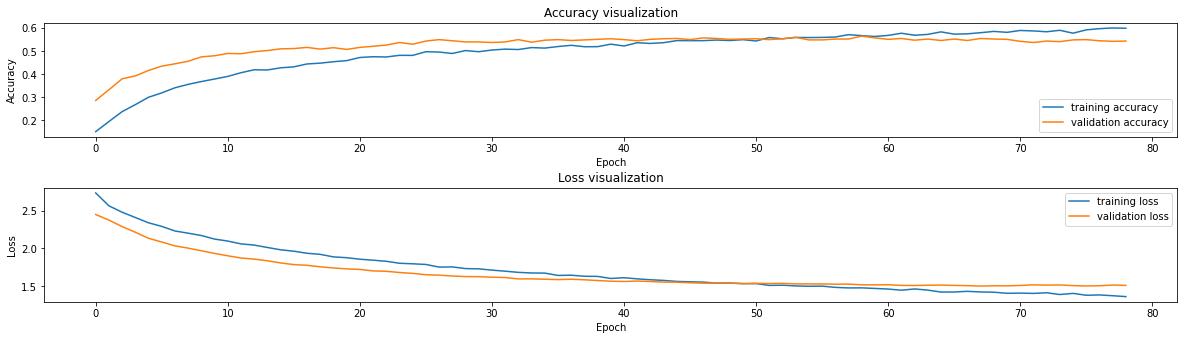

In [69]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (17, 5)

fig, axs = plt.subplots(2)
fig.tight_layout(pad=3.0)
# create accuracy sublpot
axs[0].plot(history.history["accuracy"], label="training accuracy")
axs[0].plot(history.history["val_accuracy"], label="validation accuracy")
axs[0].set_ylabel("Accuracy")
axs[0].set_xlabel("Epoch")
axs[0].legend(loc="lower right")
axs[0].set_title("Accuracy visualization")

# create error sublpot
axs[1].plot(history.history["loss"], label="training loss")
axs[1].plot(history.history["val_loss"], label="validation loss")
axs[1].set_ylabel("Loss")
axs[1].set_xlabel("Epoch")
axs[1].legend(loc="upper right")
axs[1].set_title("Loss visualization")

plt.show()

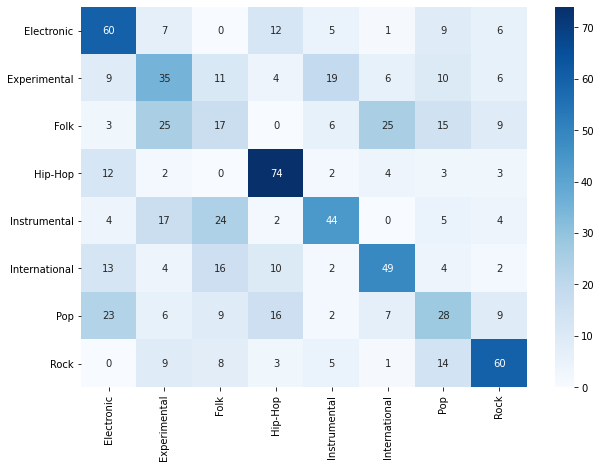

In [44]:
y_pred_test = np.argmax(model.predict(X_test),axis=1)
C_fnn = confusion_matrix(y_true=y_test, y_pred=y_pred_test)
c_fnn = pd.DataFrame(C_fnn, index = enc.classes_,columns=enc.classes_)
plt.figure(figsize=(10,7))
sn.heatmap(c_fnn,annot=True,cmap='Blues',fmt='g')
plt.show()

In [48]:
from sklearn.neighbors import NearestNeighbors
def playlist_builder(song_feature,k):
  weights = model.predict(X_train_not_shuffled)
  song_weight = model.predict(song_feature.reshape(1,-1))
  nbrs = NearestNeighbors(n_neighbors=k, algorithm='auto').fit(weights)
  dist, index = nbrs.kneighbors(song_weight)
  print('Predicted genre of input song: {} \n'.format(enc.inverse_transform([np.argmax(model.predict(song_feature.reshape(1,-1)))])))
  for j in range(k):
    id = index[0,j]
    lag_id = train[id]
    lag_title = tracks['track'].loc[lag_id]['title']
    lag_genre = tracks['track'].loc[lag_id]['genre_top']
    lag_album = tracks['artist'].loc[lag_id]['name']
    print('Lag: {}, LagId: {}, Artist: {}, Genre: {} \n'.format(lag_title,lag_id,lag_album,lag_genre))

In [31]:
def feature_computation(f, n_mfcc = 20): #Mfcc computated as in features.py
  song_feature = np.zeros(7*n_mfcc)
  song_feature[:n_mfcc] = stats.kurtosis(f, axis=1)
  song_feature[n_mfcc:2*n_mfcc] = np.max(f, axis=1)
  song_feature[2*n_mfcc:3*n_mfcc] = np.mean(f, axis=1)
  song_feature[3*n_mfcc:4*n_mfcc] = np.median(f, axis=1)
  song_feature[4*n_mfcc:5*n_mfcc] = np.min(f, axis=1)
  song_feature[5*n_mfcc:6*n_mfcc] = stats.skew(f, axis=1)
  song_feature[6*n_mfcc:7*n_mfcc] = np.std(f, axis=1)
  scaler.transform(song_feature.reshape(1,-1)) #Scaling new song with same scaler as before
  return song_feature

In [32]:
def load_audio(filepath):
  x, sr = librosa.load(filepath,sr=None, mono=True) 
  n_mfcc = 20
  stft = np.abs(librosa.stft(x, n_fft=2048, hop_length=512))
  mel = librosa.feature.melspectrogram(sr=sr, S=stft**2)
  f = librosa.feature.mfcc(S=librosa.power_to_db(mel), n_mfcc=n_mfcc)
  song_feature = feature_computation(f)
  return song_feature

'Hangloose' is a song by Hip-Hop artist AWOL. This song is a part of the fma database but not on the fma_small subset. AWOL has three other songs in the fma_small dataset. The model does not reccomend any of his other songs which is disapointing however the song is correctly classified and all the other songs are also Hip-Hop songs.

In [49]:
filepath = 'AWOL - Hangloose.mp3'
playlist_builder(load_audio(filepath),10)

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Predicted genre of input song: ['Hip-Hop'] 

Lag: The Rebel featuring Cheese N Pot-C, LagId: 137895, Artist: C-Doc, Genre: Hip-Hop 

Lag: Demmadont, LagId: 110448, Artist: Papascandy, Genre: International 

Lag: In the Dark, LagId: 7492, Artist: BrokeMC, Genre: Hip-Hop 

Lag: Four, Floss, Five, Six, LagId: 57820, Artist: Blue Ducks, Genre: Hip-Hop 

Lag: Cara de Poker, LagId: 71225, Artist: J-K, Genre: Hip-Hop 

Lag: Hell Yeah, LagId: 97692, Artist: Tickle, Genre: Hip-Hop 

Lag: 08 BEATEN TRACK, LagId: 141164, Artist: godmanwho, Genre: Hip-Hop 

Lag: DrummMachine (Prez Ike's Drums of Life Redux) (Featuring DJ Def Chad), LagId: 74955, Artist: C-Doc, Genre: Hip-Hop 

Lag: Take The Blame, LagId: 72788, Artist: Tha Silent Partner, Genre: Hip-Hop 

Lag: Follow That, LagId: 7490, Artist: BrokeMC, Genre: Hip-Hop 



'Tangled Up In Blue' is a song by Nobel-prize winner Bod Dylan. According to Wikipedia it's a folk-rock song. The model makes some wierd international and pop suggestions, however the a few of the songs are folk songs as expected.

In [46]:
filepath = '01 Tangled Up In Blue.mp3'
playlist_builder(load_audio(filepath),10)

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Predicted genre of input song: ['International'] 

Lag: Herasinkuoleena, LagId 4102, Artist: Polka Madre, Genre: International 

Lag: Outro, LagId 24362, Artist: Cuban Cowboys, Genre: International 

Lag: Bili_Ptaci (White Birds), LagId 37325, Artist: Zuby Nehty, Genre: Pop 

Lag: Small Town Industry, LagId 134384, Artist: Scott Holmes, Genre: Pop 

Lag: -Misket, LagId 134933, Artist: Turku, Nomads of the Silk Road, Genre: International 

Lag: Falling Off the Map, LagId 26464, Artist: Spectre Folk, Genre: Folk 

Lag: Invitation, LagId 131792, Artist: Pranavibes, Genre: Instrumental 

Lag: Where Will You Go, LagId 81082, Artist: Jacco Gardner, Genre: Folk 

Lag: Deep River Blues, LagId 13927, Artist: Janet Bean, Genre: Folk 

Lag: When It Rains, LagId 5940, Artist: Howard Fishman, Genre: Folk 



'My Old Man' is a song from the Canadian artist Mac DeMarco. DeMarco's music is an indie blend of folk and pop. Therfor the model does a good job by predicting both folk and pop songs.

In [47]:
filepath = '01 My Old Man.mp3'
playlist_builder(load_audio(filepath),10)

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Predicted genre of input song: ['Pop'] 

Lag: When He's Away, LagId 150062, Artist: Finn Anderson, Genre: Folk 

Lag: We Have Moved, LagId 69793, Artist: Chris Cook, Genre: Experimental 

Lag: Gnos Levohs, LagId 26322, Artist: Karl Blau, Genre: Experimental 

Lag: Different Day, LagId 13197, Artist: First, Genre: Pop 

Lag: Stay On Course, LagId 69789, Artist: Chris Cook, Genre: Experimental 

Lag: The One We Love the Most, LagId 129694, Artist: Derek Clegg, Genre: Folk 

Lag: Para Tomás, LagId 115925, Artist: Síndrome Amok, Genre: Folk 

Lag: Suspicious, LagId 54234, Artist: Ivy, Genre: Pop 

Lag: Skyvory, LagId 113934, Artist: Chris Herb, Genre: Pop 

Lag: Shane, LagId 56275, Artist: Orca Team, Genre: Pop 

